# **Kaggle Plant Pathology Classification with Xception Model**

Dataset based on: The Plant Pathology 2020 challenge dataset to classify foliar disease of apples
Ranjita Thapa (1), Noah Snavely (2), Serge Belongie (2), Awais Khan (1) ((1) Plant Pathology and Plant-Microbe Biology Section, Cornell University, Geneva, NY, (2) Cornell Tech) (https://arxiv.org/abs/2004.11958)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import shutil
import cv2
import numpy as np

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, MaxPooling2D, Flatten, BatchNormalization, GaussianNoise, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

import pandas as pd,numpy as np,pylab as pl

%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
#### Trainings DATAFRAME #########

from IPython.display import Image
data_dir = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/'
training_images = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/images/'

traindf=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Plant Pathology/train.csv', dtype=str)

traindf['healthy'] = traindf['healthy'].astype(str)
traindf['multiple_diseases'] = traindf['multiple_diseases'].astype(str)
traindf['rust'] = traindf['rust'].astype(str)
traindf['scab'] = traindf['scab'].astype(str)

def append_ext(fn):
    return fn+".jpg"
traindf["image_id"]=traindf["image_id"].apply(append_ext)


In [4]:
print('multiple_diseases :')
traindf['multiple_diseases'].value_counts()

multiple_diseases :


0    1730
1      91
Name: multiple_diseases, dtype: int64

## Balancing of the classes by resampling

In [5]:
# Re-sampling process

from sklearn.utils import resample

md_index_array = np.where(traindf['multiple_diseases']=='1')[0]
md_data = np.take(traindf, md_index_array, axis=0)
md_resampled = resample(md_data, n_samples = traindf['rust'].value_counts()[1], random_state = 7) #Up-smapling #Conacatenate to get up-sampled Xu and yu.

train_array = np.concatenate((traindf, md_resampled), axis=0)

np.random.shuffle(train_array)
traindf = pd.DataFrame({'image_id': train_array[:, 0], 
                        'healthy': train_array[:, 1],
                        'multiple_diseases': train_array[:, 2],
                        'rust': train_array[:, 3],
                        'scab': train_array[:, 4]
                        })
print('healthy :')
traindf['healthy'].value_counts()

healthy :


0    1927
1     516
Name: healthy, dtype: int64

In [6]:
print('multiple_diseases :')
traindf['multiple_diseases'].value_counts()

multiple_diseases :


0    1730
1     713
Name: multiple_diseases, dtype: int64

In [7]:
print('rust :')
traindf['rust'].value_counts()

rust :


0    1821
1     622
Name: rust, dtype: int64

In [8]:
print('scab :')
traindf['scab'].value_counts()

scab :


0    1851
1     592
Name: scab, dtype: int64

## Data preprocessing (rescale, noise, data augmentation)

In [9]:
#### DATA PREPROZESSING ####

image_size = 299 # All images will be resized to 299x299
batch_size = 32
import random

def add_noise(img):
    #Add random noise to an image
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

# Prepare data-augmenting data generator

train_datagen_I = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.5,1.5],
    rotation_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True, 
    preprocessing_function=add_noise,
    validation_split=0.2
)
validation_datagen_I=ImageDataGenerator(rescale=1./255.,validation_split=0.2)
train_generator_I = train_datagen_I.flow_from_dataframe(dataframe=traindf, directory=training_images,
                                             x_col='image_id',
                                             y_col=['healthy','multiple_diseases','rust','scab'],
                                             target_size=(image_size, image_size),
                                             batch_size=batch_size,
                                             class_mode='raw',
                                             subset='training',
                                             shuffle=True,
                                             seed=7)
validation_generator_I = validation_datagen_I.flow_from_dataframe(dataframe=traindf, directory=training_images,
                                             x_col='image_id',
                                             y_col=['healthy','multiple_diseases','rust','scab'],
                                             target_size=(image_size, image_size),
                                             class_mode='raw',
                                             batch_size=batch_size,
                                             shuffle=True,
                                             subset='validation',
                                             seed=7)

Found 1955 validated image filenames.
Found 488 validated image filenames.


### **Show images (optional)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


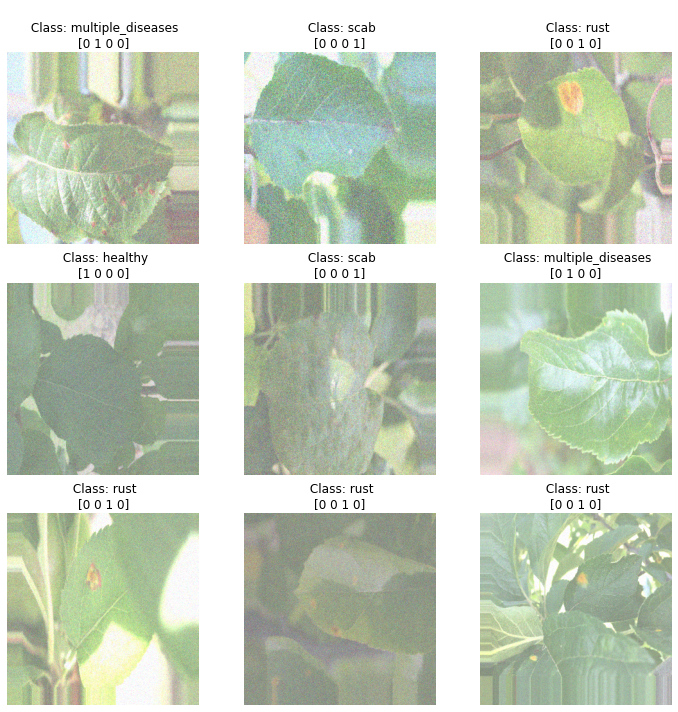

In [10]:
####   SHOW AUGMENTED IMAGES   ####

import typing
def plot_images_with_labels(
    images: typing.List[int], labels: np.ndarray, class_names: typing.List[str]) -> None:
    if len(images) != 9:
        images = images[:9]
        labels = labels[:9]
    labels = labels.astype(int)

    plt.figure(figsize=(12, 12))
    index = 0
    for image, label in zip(images, labels):
        index += 1
        plt.subplot(3, 3, index)
        plt.imshow(image)
        plt.title("\n Class: " + format(class_names[label.argmax()]) + "\n" + format(label))
        plt.axis("off")

# plot some augmented images
X_augmented, y_augmented = next(train_generator_I)
plot_images_with_labels((X_augmented + 1) / 2, y_augmented, ['healthy','multiple_diseases','rust','scab'])

## **Transfer learning model with Xception pre-train model and a new Fully-Connected-Classifier**
*   ### with fine-tuning
*   ### with data augmentation
*   ### Optimizer Adam(lr=0.0001)

In [11]:
####    BILD THE MODEL WITH XCEPTION AND ADAM OPTIMIZER ####

n_classes = 4
# build a transfer learning model with Xception and a new Fully-Connected-Classifier
base_model = Xception(
    weights='imagenet',
    include_top=False
)
for layer in base_model.layers:
  layer.trainable = True

model = GlobalAveragePooling2D()(base_model.output)
model = Dropout(0.5)(model)

# include new Fully-Connected-Classifier
output_layer = Dense(n_classes, activation='softmax')(model)

# create Model
model = Model(base_model.input, output_layer)
#model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Compile and fit the model with label smoothing

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=['accuracy']
)
steps_per_epoch = train_generator_I.n // batch_size
validation_steps = validation_generator_I.n // batch_size

print(steps_per_epoch)
historyI = model.fit_generator(train_generator_I,
                              steps_per_epoch = steps_per_epoch,
                              epochs=30,
                              validation_data=validation_generator_I)

61
Epoch 1/30
61/61 [==============================] - 192s 3s/step - loss: 1.0774 - acc: 0.5231 - val_loss: 0.6197 - val_acc: 0.7992
Epoch 2/30
61/61 [==============================] - 185s 3s/step - loss: 0.5699 - acc: 0.7915 - val_loss: 0.4941 - val_acc: 0.8381
Epoch 3/30
61/61 [==============================] - 184s 3s/step - loss: 0.3947 - acc: 0.8716 - val_loss: 0.3472 - val_acc: 0.8648
Epoch 4/30
61/61 [==============================] - 182s 3s/step - loss: 0.3345 - acc: 0.8934 - val_loss: 0.2271 - val_acc: 0.9344
Epoch 5/30
61/61 [==============================] - 183s 3s/step - loss: 0.2369 - acc: 0.9293 - val_loss: 0.2265 - val_acc: 0.9303
Epoch 6/30
61/61 [==============================] - 183s 3s/step - loss: 0.2143 - acc: 0.9464 - val_loss: 0.2933 - val_acc: 0.9201
Epoch 7/30
61/61 [==============================] - 184s 3s/step - loss: 0.2190 - acc: 0.9438 - val_loss: 0.1667 - val_acc: 0.9590
Epoch 8/30
61/61 [==============================] - 184s 3s/step - loss: 0.2024 

In [13]:
# Save model weights

print('saving model')
model.save('/content/drive/My Drive/Colab Notebooks/Plant Pathology/xc_adam_ls_cb_noise_brightn_range_last_jm.h5')
print('model saved')

saving model
model saved


In [0]:
#model = load_model('/content/drive/My Drive/Colab Notebooks/Plant Pathology/xc_adam_ls_cb_noise_brightn_range_last_jm.h5')

## Prediction

In [15]:
#### DATA PREDICTION ####
data_dir = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/'
test_images = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/images/'

testdf=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Plant Pathology/test.csv', dtype=str)
def append_ext(fn):
    return fn+".jpg"
testdf["image_id"]=testdf["image_id"].apply(append_ext)
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
image_size = 299 # All images will be resized to 299x299
batch_size = 1

test_generator = test_datagen.flow_from_dataframe(dataframe=testdf, directory=test_images,
                                             x_col='image_id',
                                             target_size=(image_size, image_size),
                                             batch_size=batch_size,
                                             class_mode=None,
                                             shuffle=False)


filenames = test_generator.filenames
nb_samples = len(filenames)

steps = test_generator.n // batch_size

predict = model.predict_generator(test_generator, steps)

test_image_id=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Plant Pathology/test.csv', dtype=str)
predict_with_id = np.c_[ test_image_id["image_id"], predict]
np.savetxt(data_dir + "prediction_adam_ls_cb_noise_brightn_range_last.csv", predict_with_id, fmt="%s,%10.2f,%10.2f,%10.2f,%10.2f")
#np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
#print("Accuracy = ", predict_with_id[:10])


Found 1821 validated image filenames.


## Draw accuracy plot

In [0]:
def plot_learning_curve(
    title: str, x: int, y: int, y_test: int, ylim: float = 0.6
) -> None:
    plt.figure()
    plt.title(title)
    axes = plt.gca()
    axes.set_ylim([ylim, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    train_sizes = x
    train_scores = y
    test_scores = y_test

    plt.grid()

    plt.plot(
        train_sizes,
        train_scores,
        "o-",
        color=(177 / 255, 6 / 255, 58 / 255),
        label="Training accuracy",
    )
    plt.plot(
        train_sizes,
        test_scores,
        "o-",
        color=(246 / 255, 168 / 255, 0),
        label="Validation accuracy",
    )

    plt.legend(loc="best")


def plot_history(title: str, history: "History", ylim: float = 0.6) -> None:
    y = history.history["acc"]
    y_test = history.history["val_acc"]
    plot_learning_curve(title, np.arange(1, 1 + len(y)), y, y_test, ylim)



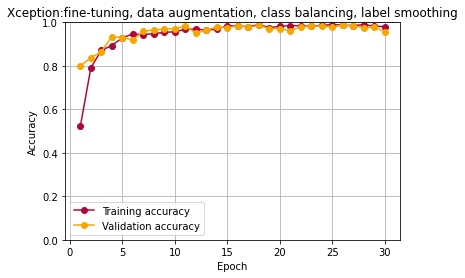

In [17]:
plot_history('Xception:fine-tuning, data augmentation, class balancing, label smoothing', historyI, 0)


## Submit to Kaggle

In [3]:

!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adl14jm","key":"48660192e9a20da7d97d1f36b2a8f3f8"}'}

In [4]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f "/content/drive/My Drive/Colab Notebooks/prediction_adam_ls_cb_noise_brightn_range_last.csv" -m "Message: ADL14JM 4"

100% 95.0k/95.0k [00:03<00:00, 31.1kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

## Summary
### I chose Xception as my pre-trained model. Without fine-tuning, the results were not at all satisfactory - accuracy about 0.5. It didn't matter which optimizer I used or how the learning rate was set.
### The breakthrough came through fine-tuning. The Adam Optimizer was able to achieve better results than RMSProp or SGD 
### A good improvement of the performance was shown by the balancing of the classes, label smoothing and brightness range. But more than 94,1% on Kaggle I still could not reach.